[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/iabh1shekbasu/LungCancerDetectionEnsemble/blob/main/Probability_Extraction_and_Analysis.ipynb

)


## Connecting Google Drive

In [1]:
!pip cache purge
# !!pip install numpy==1.22.4 pandas==1.5.3 scipy==1.8.1
# !pip cache purge
# !pip install scipy==1.7.3
# !pip install --force-reinstall --no-deps scipy==1.14.1

Files removed: 8


In [2]:
!pip install --force-reinstall --no-cache-dir scipy==1.14.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 224.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 279.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 281.3 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.10.1 requires cubinlinker, which is not installed.
cudf 24.10.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.10.1 requires libcudf==24.10.*, which is not insta

In [3]:
!pip uninstall scikit-plot -y
!pip install scikit-plot

Found existing installation: scikit-plot 0.3.7
Uninstalling scikit-plot-0.3.7:
  Successfully uninstalled scikit-plot-0.3.7
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 79.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.10.1 requires cubinlinker, which is not installed.
cudf 24.10.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.10.1 requires libcudf==24.10.*, which is not installed.
cudf 24.10.1 requires ptxcompiler, which is not installed.
cuml 24.10.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 24.10.0 requires cuvs==24.10.*, which is not installed.
cuml

In [4]:
# !pip uninstall scikit-plot -y
!pip install scikit-plot

In [ ]:
# pip install scipy==1.6.3


In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
import matplotlib.pyplot as plt
import math,os,argparse
# from scikitplot.estimators import plot_feature_importances
# from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

In [ ]:
# !mkdir /content/drive

In [ ]:
# from google.colab import drive

# drive.mount('/content/drive')
# https://drive.google.com/drive/folders/1pk4XWbn5PVPS4OQmj3GhBHq5fd0QAYZk?usp=drive_link

In [7]:
# !google-drive-ocamlfuse

# !ls '/kaggle/input/ensemble-learning-on-lidc-dataset/data'
# List contents of the data directory
data_dir = "/kaggle/input/ensemble-learning-on-lidc-dataset/data"
print("Contents of data directory:")
!ls "{data_dir}"

Contents of data directory:
densenet169.h5	       resnet152_test.csv  train
densenet169_test.csv   test		   train_labels.csv
densenet169_train.csv  test_labels.csv	   val


In [ ]:
# !xdg-settings set default-web-browser w3m.desktop # to set default browser

# %cd /content

# !mkdir drive

# %cd drive

# !mkdir MyDrive

# %cd ..

# %cd ..

# !google-drive-ocamlfuse /content/drive/MyDrive

## Importing Libraries



This section imports necessary libraries required for the entire notebook. It includes deep learning libraries such as PyTorch, data manipulation libraries like NumPy, and visualization libraries such as matplotlib.

In [8]:
import time

import os

import copy

import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score

import torch

import torch.nn as nn

import torch.optim as optim

from torch.optim import lr_scheduler

import torchvision

from torchvision import datasets, models, transforms

from torch.utils.data import WeightedRandomSampler, DataLoader
# Set device for training (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Data Preprocessing



This section defines the transformations to be applied to the input data for training and evaluation purposes. It includes normalization, resizing, and augmentation strategies.

In [14]:
mean = np.array([0.5, 0.5, 0.5])

std = np.array([0.5, 0.5, 0.5])

In [28]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
        transforms.ColorJitter(brightness=0.2),
        transforms.RandomRotation(degrees=25),
        transforms.RandomHorizontalFlip(p=0.25),
        transforms.RandAugment(num_ops=4),
        transforms.Resize((256, 256)),  # Ensure consistent output size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ]),
}


## Data Directory Setup



This sets the path to the directory where the dataset is stored. It's essential for the notebook to access the training and testing data.

In [29]:
# Load datasets and create dataloaders for training, validation, and testing 
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

print("Classes:", class_names)

Classes: ['benign', 'malignant']


In [30]:
# # data_dir = "/content/drive/MyDrive/Ensemble Learning on LIDC Dataset/data"  # Set the directory for the data

# # image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),

# #                                           data_transforms[x])

# #                   for x in [ 'test', 'train', 'val']}

# # dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,

# #                                              shuffle=True, num_workers=2)

# #               for x in ['train', 'val','test']}

# # dataset_sizes = {x: len(image_datasets[x]) for x in ['test', 'train', 'val']}

# # class_names = image_datasets['train'].classes

# # num_classes = len(class_names)

# # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # print(class_names)

# # Set the path to the data directory

# data_dir = "/kaggle/input/ensemble-learning-on-lidc-dataset/data"



# # Verify the contents of the data directory

# print("Contents of data directory:")

# !ls "{data_dir}"



# # Load the datasets

# data_transforms = {

#     'train': transforms.Compose([

#         transforms.Resize((256, 256)),

#         transforms.ToTensor(),

#         transforms.Normalize(mean, std),

#     ]),

#     'val': transforms.Compose([

#         transforms.Resize((256, 256)),

#         transforms.ToTensor(),

#         transforms.Normalize(mean, std),

#     ]),

#     'test': transforms.Compose([

#         transforms.Resize((256, 256)),

#         transforms.ToTensor(),

#         transforms.Normalize(mean, std),

#     ]),

# }



# # Define the datasets and dataloaders

# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])

#                   for x in ['train', 'val', 'test']}

# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,

#                                              shuffle=True, num_workers=2)

#                for x in ['train', 'val', 'test']}

# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

# class_names = image_datasets['train'].classes

# num_classes = len(class_names)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



# # Display the class names

# print("Classes:", class_names)


## Visualization Function



Here we define a function to visualize images in the dataset. It will help in understanding the data and debugging the data loaders.

In [31]:
def imshow(inp, title):

    """Imshow for Tensor."""

    inp = inp.numpy().transpose((1, 2, 0))

    inp = std * inp + mean

    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)

    plt.title(title)

    plt.show()

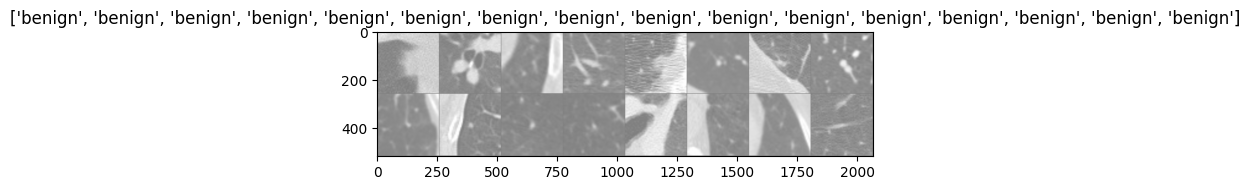

In [32]:
# Get a batch of testing data

inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [33]:
def plot(val_loss,train_loss,typ):

    plt.title("{} after epoch: {}".format(typ,len(train_loss)))

    plt.xlabel("Epoch")

    plt.ylabel(typ)

    plt.plot(list(range(len(train_loss))),train_loss,color="r",label="Train "+typ)

    plt.plot(list(range(len(val_loss))),val_loss,color="b",label="Validation "+typ)

    plt.legend()

    plt.savefig(os.path.join(data_dir,typ+".png"))

    plt.close()

In [34]:
val_loss_gph=[]

train_loss_gph=[]

val_acc_gph=[]

train_acc_gph=[]

## Model Training Function



This function encapsulates the model training logic. It takes a model, criterion for loss calculation, optimizer for backpropagation, and a scheduler for learning rate adjustment as inputs and conducts the training process.

In [35]:
!pip install torchsummary

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import torchsummary

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)

    def forward(self, x):
        batch, channels, _, _ = x.size()
        y = x.view(batch, channels, -1).mean(dim=2)  # Global average pooling
        y = nn.functional.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y))
        y = y.view(batch, channels, 1, 1)
        return x * y

class ResidualSEBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualSEBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels,
                          out_channels,
                          kernel_size=1,
                          stride=stride,
                          bias=False),
                nn.BatchNorm2d(out_channels),
            )
            
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        
        return self.relu(out)

class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        
        self.backbone = nn.Sequential(
            nn.Conv2d(3 ,64 ,kernel_size=7 ,stride=2 ,padding=3 ,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3 ,stride=2 ,padding=1),
            self._make_layer(64 ,64 ,3),
            self._make_layer(64 ,128 ,4 ,stride=2),
            self._make_layer(128 ,256 ,6 ,stride=2),
            self._make_layer(256 ,512 ,3 ,stride=2),
            nn.AdaptiveAvgPool2d((1 ,1))
        )
        
        # Final classification layer 
        self.cls_layer = nn.Linear(512 ,num_classes)

    def _make_layer(self,in_channels,out_channels,num_blocks,stride=1):
        downsample=None
        
        if stride != 1 or in_channels != out_channels:
            downsample=nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channels),
            )
        
        layers=[ResidualSEBlock(in_channels,out_channels,stride=stride)]
        
        for _ in range(1,num_blocks):
            layers.append(ResidualSEBlock(out_channels,out_channels))
        
        return nn.Sequential(*layers)

    def forward(self,x):
        feats=self.backbone(x)
        
        feats=feats.view(feats.size(0),-1) 
       
        out=self.cls_layer(feats) 
        
        return {"feats": feats,"out": out}

In [66]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class ChannelAttention(nn.Module):
#     def __init__(self, num_channels, reduction_ratio=16):
#         super(ChannelAttention, self).__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.max_pool = nn.AdaptiveMaxPool2d(1)
#         self.fc = nn.Sequential(
#             nn.Linear(num_channels, num_channels // reduction_ratio, bias=False),
#             nn.ReLU(),
#             nn.Linear(num_channels // reduction_ratio, num_channels, bias=False)
#         )
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         avg_out = self.fc(self.avg_pool(x).view(x.size(0), -1))
#         max_out = self.fc(self.max_pool(x).view(x.size(0), -1))
#         out = avg_out + max_out
#         return self.sigmoid(out).view(x.size(0), x.size(1), 1, 1)

# class SpatialAttention(nn.Module):
#     def __init__(self, kernel_size=7):
#         super(SpatialAttention, self).__init__()
#         self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         avg_out = torch.mean(x, dim=1, keepdim=True)
#         max_out, _ = torch.max(x, dim=1, keepdim=True)
#         x = torch.cat([avg_out, max_out], dim=1)
#         x = self.conv1(x)
#         return self.sigmoid(x)

# class CBAMBlock(nn.Module):
#     def __init__(self, num_channels, reduction_ratio=16, kernel_size=7):
#         super(CBAMBlock, self).__init__()
#         self.channel_attention = ChannelAttention(num_channels, reduction_ratio)
#         self.spatial_attention = SpatialAttention(kernel_size)

#     def forward(self, x):
#         x = x * self.channel_attention(x)
#         x = x * self.spatial_attention(x)
#         return x


In [67]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class ChannelAttention(nn.Module):
#     def __init__(self, num_channels, reduction_ratio=16):
#         super(ChannelAttention, self).__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.max_pool = nn.AdaptiveMaxPool2d(1)
#         self.fc1 = nn.Linear(num_channels, num_channels // reduction_ratio, bias=False)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(num_channels // reduction_ratio, num_channels, bias=False)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         avg_pooled = self.avg_pool(x).view(x.size(0), -1)
#         max_pooled = self.max_pool(x).view(x.size(0), -1)
#         avg_out = self.fc1(avg_pooled)
#         avg_out = self.relu(avg_out)
#         avg_out = self.fc2(avg_out)
#         max_out = self.fc1(max_pooled)
#         max_out = self.relu(max_out)
#         max_out = self.fc2(max_out)
#         out = avg_out + max_out
#         return self.sigmoid(out).view(x.size(0), x.size(1), 1, 1)

# class SpatialAttention(nn.Module):
#     def __init__(self, kernel_size=7):
#         super(SpatialAttention, self).__init__()
#         self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         avg_out = torch.mean(x, dim=1, keepdim=True)
#         max_out, _ = torch.max(x, dim=1, keepdim=True)
#         x = torch.cat([avg_out, max_out], dim=1)
#         x = self.conv1(x)
#         return self.sigmoid(x)

# class CBAM(nn.Module):
#     def __init__(self, num_channels, reduction_ratio=16, kernel_size=7):
#         super(CBAM, self).__init__()
#         self.channel_attention = ChannelAttention(num_channels, reduction_ratio)
#         self.spatial_attention = SpatialAttention(kernel_size)

#     def forward(self, x):
#         x = x * self.channel_attention(x)
#         x = x * self.spatial_attention(x)
#         return x


In [68]:
# import torch
# import torch.nn as nn
# from torchsummary import summary

# # Assuming 'Network' is your custom model class, which you should define or import
# class Network(nn.Module):
#     def __init__(self, num_classes=10):  # Set the default number of classes to 10
#         super(Network, self).__init__()
#         # Example layers
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
#         self.bn1 = nn.BatchNorm2d(16)
#         self.relu = nn.ReLU(inplace=True)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.cbam = CBAM(16)  # Example usage of CBAM with 16 channels
#         # Continue building your network architecture
#         self.fc = nn.Linear(16 * 56 * 56, num_classes)  # Adjust size according to your architecture

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.pool(x)
#         x = self.cbam(x)  # Apply CBAM module after initial layers
#         x = x.view(x.size(0), -1)  # Flatten the features for the fully connected layer
#         x = self.fc(x)
#         return x

# # Initialize the model and transfer it to the appropriate device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = Network().to(device)

# # Use torchsummary to print the summary of the model
# summary(model, (3, 112, 112))


In [69]:
# Initialize the model and print summary 
model = Network().to(device)
from torchsummary import summary

summary(model,(3 ,112 ,112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           9,408
       BatchNorm2d-2           [-1, 64, 56, 56]             128
              ReLU-3           [-1, 64, 56, 56]               0
         MaxPool2d-4           [-1, 64, 28, 28]               0
            Conv2d-5           [-1, 64, 28, 28]          36,864
       BatchNorm2d-6           [-1, 64, 28, 28]             128
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]          36,864
       BatchNorm2d-9           [-1, 64, 28, 28]             128
           Linear-10                    [-1, 4]             256
           Linear-11                   [-1, 64]             256
          SEBlock-12           [-1, 64, 28, 28]               0
             ReLU-13           [-1, 64, 28, 28]               0
  ResidualSEBlock-14           [-1, 64,

In [80]:
import torch.optim as optim
from torch.optim import lr_scheduler

# Criterion with class weights for handling imbalances 
weights=torch.tensor([1.0 ,4.7], device=device) 
# criterion=nn.CrossEntropyLoss(weight=weights) 

# # Optimizer 
# optimizer=optim.Adam(model.parameters(), lr=0.0001) 

# # Learning rate scheduler 
# scheduler=lr_scheduler.StepLR(optimizer ,step_size=10 ,gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()

# --------------------------------------------------- #

# Defining Optimizer
#optimizer =  # TODO: Feel free to pick a optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=1e-4)

# --------------------------------------------------- #
import torch.optim as optim

# Define the SGD optimizer
optimizer = optim.SGD(
    model.parameters(),      # Model parameters to update
    lr=0.01,                 # Learning rate, which you can adjust based on experimentation
    momentum=0.9,            # Momentum for faster convergence
    weight_decay=1e-4        # Weight decay for regularization
)

# Optionally, define a learning rate scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

In [81]:
import wandb
wandb.login(key = '889736f968fd287026464ea18bead25ea75991d4')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [82]:

config={
   "learning_rate":0.0001,
   "epochs":10,
   "batch_size":64,
   "loss_function":"CrossEntropyLoss",
   "architecture":"SERESNET",
   "dataset":"Your Dataset Name"
}

# Create your wandb run 
run=wandb.init(
   name="SERESNET SGD Second ",
   reinit=True,
   project="IDL_Project",
   config=config 
)

In [83]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()  # Zero the parameter gradients

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # Access the actual output for loss and accuracy computation
                    output_tensor = outputs['out']  
                    _, preds = torch.max(output_tensor, 1)
                    loss = criterion(output_tensor, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model if it has the best accuracy on validation set
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model


In [84]:
trained_model = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    device=device,  # Ensure this is defined and passed correctly
    num_epochs=config['epochs']
)


Epoch 1/10
----------
train Loss: 0.4123 Acc: 0.8392
val Loss: 0.4801 Acc: 0.8273
Epoch 2/10
----------
train Loss: 0.4067 Acc: 0.8406
val Loss: 0.5512 Acc: 0.8311
Epoch 3/10
----------
train Loss: 0.3873 Acc: 0.8471
val Loss: 0.3944 Acc: 0.8520
Epoch 4/10
----------
train Loss: 0.3702 Acc: 0.8481
val Loss: 0.3819 Acc: 0.8419
Epoch 5/10
----------
train Loss: 0.3476 Acc: 0.8635
val Loss: 0.3428 Acc: 0.8712
Epoch 6/10
----------
train Loss: 0.3156 Acc: 0.8778
val Loss: 0.3072 Acc: 0.8805
Epoch 7/10
----------
train Loss: 0.2990 Acc: 0.8834
val Loss: 0.2974 Acc: 0.8843
Epoch 8/10
----------
train Loss: 0.2769 Acc: 0.8909
val Loss: 0.2805 Acc: 0.8828
Epoch 9/10
----------
train Loss: 0.2577 Acc: 0.8959
val Loss: 0.2786 Acc: 0.8990
Epoch 10/10
----------
train Loss: 0.2400 Acc: 0.9030
val Loss: 0.2535 Acc: 0.9013
Training complete in 6m 40s
Best val Acc: 0.901311


In [87]:
# Assuming 'num_classes' is defined correctly elsewhere in your code
import torch
import numpy as np
import csv
from torch.utils.data import DataLoader

model.eval()  # Ensure the model is in evaluation mode
data_dir = "/kaggle/working/"
trainloader = DataLoader(image_datasets['train'], batch_size=config['batch_size'])

f = open(data_dir + "seresnet.csv", 'w+', newline='')
writer = csv.writer(f)

# Create a list to save filenames and an array to hold probabilities
saving = []
temp_array = np.zeros((len(trainloader.dataset), num_classes))  # Adjust array size to dataset size

correct = 0
total = 0

with torch.no_grad():
    index = 0  # To track where to place results in temp_array
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)['out']
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        prob = torch.nn.functional.softmax(outputs, dim=1)
        for j in range(images.size(0)):  # Iterate over each item in the batch
            saving.append(trainloader.dataset.samples[index][0].split('/')[-1])
            temp_array[index] = prob[j].cpu().numpy()  # Store probabilities for each class
            index += 1

# Calculate and print train accuracy
train_accuracy = (100 * correct / total)
print("Train Accuracy =", train_accuracy)

# Write to CSV
for i in range(len(saving)):
    k = temp_array[i].tolist()
    k.append(saving[i])
    writer.writerow(k)

f.close()

# Optionally log accuracy to Weights & Biases
# wandb.log({"train_accuracy": train_accuracy})


Train Accuracy = 91.03528050896472


In [89]:
import torch
import numpy as np
import csv
from torch.utils.data import DataLoader

# Assuming the testloader and model are already defined and configured
model.eval()  # Set the model to evaluation mode

# Define the path for the CSV file and open it for writing
data_dir = "/kaggle/working/"  # Make sure this directory exists
f = open(data_dir + "seresnet_test.csv", 'w+', newline='')
writer = csv.writer(f)

# Initialize lists and counters for storing results and calculating accuracy
saving = []
correct = 0
total = 0

with torch.no_grad():
    num = len(testloader.dataset)
    temp_array = np.zeros((num, num_classes))  # Ensure dimensions are correct based on your `num_classes`

    index = 0  # Track the index for proper placement in the temp_array
    for i, (images, labels) in enumerate(testloader):
        images, labels = images.to(device), labels.to(device)  # Move data to the correct device

        outputs = model(images)['out']
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        prob = torch.nn.functional.softmax(outputs, dim=1)
        for j in range(images.size(0)):  # Handle batches with more than one image
            saving.append(testloader.dataset.samples[index][0].split('/')[-1])
            temp_array[index] = prob[j].cpu().numpy()  # Extract probabilities for each image
            index += 1

# Calculate and print the test accuracy
test_accuracy = (100 * correct / total)
print("Test Accuracy =", test_accuracy)

# Write the probabilities and filenames to the CSV file
for i in range(num):
    k = temp_array[i].tolist()
    k.append(saving[i])
    writer.writerow(k)

# Close the CSV file
f.close()


Test Accuracy = 90.8754623921085


# ResNet 152

## Model Definition and Training



This section covers the instantiation of the ResNet152 model and its subsequent training with the dataset.

In [ ]:
# import torch.optim as optim
# from torch.optim import lr_scheduler

# # Criterion with class weights for handling imbalances
# weights = torch.tensor([1.0, 4.7], device=DEVICE)  # Adjust weights as needed for your application
# criterion = nn.CrossEntropyLoss(weight=weights)

# # Optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

# # Learning rate scheduler
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [ ]:
# import wandb
# wandb.login(key = '889736f968fd287026464ea18bead25ea75991d4')

In [ ]:
# config = {
#     "learning_rate": 0.0001,
#     "epochs": 10,
#     "batch_size": 64,
#     "loss_function": "CrossEntropyLoss",
#     "architecture": "SERESNET",
#     "dataset": "Your Dataset Name"
# }
# # Create your wandb run
# run = wandb.init(
#     name = "SERESNET First", ## Wandb creates random run names if you skip this field
#     reinit = True, ### Allows reinitalizing runs when you re-run this cell
#     # run_id = ### Insert specific run id here if you want to resume a previous run
#     # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
#     project = "IDL_Project", ### Project should be created in your wandb account
#     config = config ### Wandb Config for your run
# )

In [ ]:
# # model = models.resnet152(pretrained = True)

# #num_ftrs = model.classifier[0].in_features
# model = Network().to(DEVICE)

# num_ftrs = model.fc.in_features  ##for googlenet, resnet18

# #num_ftrs = model.classifier.in_features  ## for densenet169

# print("Number of features: "+str(num_ftrs))

# #model.classifier = nn.Linear(num_ftrs, num_classes) ## for vgg19

# model.fc = nn.Linear(num_ftrs, num_classes)  ##for googlenet, resnet18

# #model.classifier = nn.Linear(num_ftrs, num_classes) ## for densenet169

# model = model.to(device)

# criterion = nn.CrossEntropyLoss( weight = torch.tensor([1, 4.7]).to(device))

# # Observe that all parameters are being optimized

# optimizer = optim.Adam(model.parameters(), lr=0.0001)

# # StepLR Decays the learning rate of each parameter group by gamma every step_size epochs

# # Decay LR by a factor of 0.1 every 7 epochs

# # Learning rate scheduling should be applied after optimizer’s update

# # e.g., you should write your code this way:

# # for epoch in range(100):

# #     train(...)

# #     validate(...)

# #     scheduler.step()

# step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.1)

# model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10, model_name = "SeResnet")

In [ ]:
# # Getting Proba distribution

# print("\nGetting the Probability Distribution")

# trainloader=torch.utils.data.DataLoader(image_datasets['train'],batch_size=1)

# testloader=torch.utils.data.DataLoader(image_datasets['test'],batch_size=1)

# model=model.eval()

# import csv

# import numpy as np  # Importing NumPy for numerical operations

In [ ]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs=25,model_name = "kaggle"):

#     since = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())

#     best_acc = 0.0

#     for epoch in range(num_epochs):

#         print('Epoch {}/{}'.format(epoch+1, num_epochs))

#         print('-' * 10)

#         # Each epoch has a training and validation phase

#         for phase in ['train', 'val']:

#             if phase == 'train':

#                 model.train()  # Set model to training mode

#             else:

#                 model.eval()   # Set model to evaluate mode

#             running_loss = 0.0

#             running_corrects = 0

#             # Iterate over data.

#             for inputs, labels in dataloaders[phase]:

#                 inputs = inputs.to(device)

#                 labels = labels.to(device)

#                 # forward

#                 # track history if only in train

#                 with torch.set_grad_enabled(phase == 'train'):

#                     outputs = model(inputs)

#                     _, preds = torch.max(outputs, 1) #was (outputs,1) for non-inception and (outputs.data,1) for inception

#                     loss = criterion(outputs, labels)

#                     # backward + optimize only if in training phase

#                     if phase == 'train':

#                         optimizer.zero_grad()

#                         loss.backward()

#                         optimizer.step()

#                 # statistics

#                 running_loss += loss.item() * inputs.size(0)

#                 running_corrects += torch.sum(preds == labels.data)

#             if phase == 'train':

#                 scheduler.step()

#             epoch_loss = running_loss / dataset_sizes[phase]

#             epoch_acc = running_corrects.double() / dataset_sizes[phase]

#             if phase == 'train':

#               train_loss_gph.append(epoch_loss)

#               train_acc_gph.append(epoch_acc)

#             if phase == 'val':

#               val_loss_gph.append(epoch_loss)

#               val_acc_gph.append(epoch_acc)

#            # plot(val_loss_gph,train_loss_gph, "Loss")

#           #  plot(val_acc_gph,train_acc_gph, "Accuracy")

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(

#                 phase, epoch_loss, epoch_acc))

#             # deep copy the model

#             if phase == 'val' and epoch_acc >= best_acc:

#                 best_acc = epoch_acc

#                 best_model_wts = copy.deepcopy(model.state_dict())

#                 torch.save(model, data_dir+"/"+model_name+".h5")

#                 print('==>Model Saved')

#         print()

#     time_elapsed = time.time() - since

#     print('Training complete in {:.0f}m {:.0f}s'.format(

#         time_elapsed // 60, time_elapsed % 60))

#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights

#     model.load_state_dict(best_model_wts)

#     return model

In [ ]:
# # Train the Model
# trained_model = train_model(
#     model=model,
#     criterion=criterion,
#     optimizer=optimizer,
#     scheduler=scheduler,
#     dataloaders=dataloaders,  # Correctly passed here
#     dataset_sizes=dataset_sizes,
#     device=device,  # Correctly passed here
#     num_epochs=10
# )

In [ ]:
# import torch
# from torch.utils.data import DataLoader
# import numpy as np
# import csv

# # Define data loaders
# trainloader = DataLoader(image_datasets['train'], batch_size=config['batch_size'])
# testloader = DataLoader(image_datasets['test'], batch_size=config['batch_size'])

# # Model evaluation
# model.eval()
# # Correct directory path for writable access
# data_dir = "/kaggle/working/"

# # Attempt to open a file for writing in a writable directory
# f = open(data_dir + "seresnet.csv", 'w+', newline='')
# writer = csv.writer(f)
# saving = []
# correct = 0
# total = 0

# # Proceed with your existing code...


# with torch.no_grad():
#     temp_array = np.zeros((len(trainloader), num_classes))
#     for i, data in enumerate(trainloader):
#         images, labels = data
#         labels = labels.to(DEVICE)
#         outputs = model(images.to(DEVICE))['out']
#         _, predicted = torch.max(outputs, 1)
#         # outputs = model(images.to(DEVICE))['out']  # Directly access the 'out' tensor from the dictionary
#     	# _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#         # Calculate probabilities
#         prob = torch.nn.functional.softmax(outputs, dim=1)
#         saving.append(trainloader.dataset.samples[i][0].split('/')[-1])
#         temp_array[i] = np.asarray(prob[0].tolist()[0:num_classes])

#         # Log batch accuracy to wandb
#         wandb.log({"batch_accuracy": (predicted == labels).float().mean().item()})

# train_accuracy = 100 * correct / total
# print("Train Accuracy =", train_accuracy)

# # Log overall train accuracy to wandb
# wandb.log({"train_accuracy": train_accuracy})

# for i in range(len(trainloader)):
#     k = temp_array[i].tolist()
#     k.append(saving[i])
#     writer.writerow(k)

# f.close()

# # Log model and close wandb run
# wandb.watch(model, log="all", log_freq=10)
# run.finish()


In [ ]:
# f = open(data_dir+"/resnet152_train.csv",'w+',newline = '')

# writer = csv.writer(f)

# saving = []

# correct = 0

# total = 0

# with torch.no_grad():

#       num = 0

#       temp_array = np.zeros((len(trainloader),num_classes))

#       for i,data in enumerate(trainloader):

#           images, labels = data

#           sample_fname, _ = trainloader.dataset.samples[i]

#           labels=labels.cuda()

#           outputs = model(images.cuda())

#           _, predicted = torch.max(outputs, 1)

#           total += labels.size(0)

#           correct += (predicted == labels.cuda()).sum().item()

#           prob = torch.nn.functional.softmax(outputs, dim=1)

#           saving.append(sample_fname.split('/')[-1])

#           temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])

#           num+=1

# print("Train Accuracy = ",100*correct/total)

# for i in range(len(trainloader)):

#   k = temp_array[i].tolist()

#   k.append(saving[i])

#   writer.writerow(k)

# f.close()

# f = open(data_dir+"/train_labels.csv",'w+',newline = '')

# writer = csv.writer(f)

# for i,data in enumerate(trainloader):

#   _, labels = data

#   sample_fname, _ = trainloader.dataset.samples[i]

#   sample = sample_fname.split('/')[-1]

#   lab = labels.tolist()[0]

#   writer.writerow([sample,lab])

# f.close()


# ====================


# import csv

# import numpy as np

# import torch



# # Open file for writing predicted probabilities

# f = open(save_dir + "/resnet152_train.csv", 'w+', newline='')

# writer = csv.writer(f)

# saving = []  # To store filenames

# correct = 0  # To count correct predictions

# total = 0    # To count total samples



# with torch.no_grad():

#     num = 0

#     temp_array = np.zeros((len(trainloader), num_classes))  # Array to store probabilities



#     # Loop through training data

#     for i, data in enumerate(trainloader):

#         images, labels = data

#         sample_fname, _ = trainloader.dataset.samples[i]  # Get filename

#         labels = labels.cuda()  # Move labels to GPU

#         outputs = model(images.cuda())  # Get model predictions



#         # Calculate predicted class and accumulate accuracy metrics

#         _, predicted = torch.max(outputs, 1)

#         total += labels.size(0)

#         correct += (predicted == labels).sum().item()



#         # Calculate probabilities using softmax and store filename and probabilities

#         prob = torch.nn.functional.softmax(outputs, dim=1)

#         saving.append(sample_fname.split('/')[-1])

#         temp_array[num] = np.asarray(prob[0].tolist()[:num_classes])  # Store probabilities

#         num += 1



# # Calculate and print training accuracy

# print("Train Accuracy = ", 100 * correct / total)



# # Write predicted probabilities to CSV

# for i in range(len(trainloader)):

#     row = temp_array[i].tolist()  # Convert probabilities to list

#     row.append(saving[i])         # Append filename

#     writer.writerow(row)           # Write row to CSV

# f.close()  # Close the file



# # Open file for writing true labels

# f = open(save_dir + "/train_labels.csv", 'w+', newline='')

# writer = csv.writer(f)



# # Loop through training data to get labels

# for i, data in enumerate(trainloader):

#     _, labels = data

#     sample_fname, _ = trainloader.dataset.samples[i]  # Get filename

#     sample = sample_fname.split('/')[-1]  # Extract filename from path

#     lab = labels.tolist()[0]              # Get label as integer

#     writer.writerow([sample, lab])         # Write filename and label to CSV

# f.close()  # Close the file


In [ ]:
# #Test Probabilities

# f = open(data_dir+"/resnet152_test.csv",'w+',newline = '')

# writer = csv.writer(f)

# saving = []

# correct = 0

# total = 0

# with torch.no_grad():

#       num = 0

#       temp_array = np.zeros((len(testloader),num_classes))

#       for i,data in enumerate(testloader):

#           images, labels = data

#           sample_fname, _ = testloader.dataset.samples[i]

#           labels=labels.cuda()

#           outputs = model(images.cuda())

#           _, predicted = torch.max(outputs, 1)

#           total += labels.size(0)

#           correct += (predicted == labels.cuda()).sum().item()

#           prob = torch.nn.functional.softmax(outputs, dim=1)

#           saving.append(sample_fname.split('/')[-1])

#           temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])

#           num+=1

# print("Test Accuracy = ",100*correct/total)

# for i in range(len(testloader)):

#   k = temp_array[i].tolist()

#   k.append(saving[i])

#   writer.writerow(k)

# f.close()

# f = open(data_dir+"/test_labels.csv",'w+',newline = '')

# writer = csv.writer(f)

# for i,data in enumerate(testloader):

#   _, labels = data

#   sample_fname, _ = testloader.dataset.samples[i]

#   sample = sample_fname.split('/')[-1]

#   lab = labels.tolist()[0]

#   writer.writerow([sample,lab])

# f.close()


# #=====================


# # import csv

# # import numpy as np

# # import torch



# # # Test Probabilities

# # f = open(save_dir + "/resnet152_test.csv", 'w+', newline='')

# # writer = csv.writer(f)

# # saving = []

# # correct = 0

# # total = 0



# # with torch.no_grad():

# #     num = 0

# #     temp_array = np.zeros((len(testloader), num_classes))



# #     # Loop through test data

# #     for i, data in enumerate(testloader):

# #         images, labels = data

# #         sample_fname, _ = testloader.dataset.samples[i]  # Get filename

# #         labels = labels.cuda()  # Move labels to GPU

# #         outputs = model(images.cuda())  # Get model predictions



# #         # Calculate predicted class and accumulate accuracy metrics

# #         _, predicted = torch.max(outputs, 1)

# #         total += labels.size(0)

# #         correct += (predicted == labels).sum().item()



# #         # Calculate probabilities using softmax and store filename and probabilities

# #         prob = torch.nn.functional.softmax(outputs, dim=1)

# #         saving.append(sample_fname.split('/')[-1])

# #         temp_array[num] = np.asarray(prob[0].tolist()[:num_classes])  # Store probabilities

# #         num += 1



# # # Calculate and print test accuracy

# # print("Test Accuracy = ", 100 * correct / total)



# # # Write predicted probabilities to CSV

# # for i in range(len(testloader)):

# #     row = temp_array[i].tolist()  # Convert probabilities to list

# #     row.append(saving[i])         # Append filename

# #     writer.writerow(row)           # Write row to CSV

# # f.close()  # Close the file



# # # Open file for writing true labels

# # f = open(save_dir + "/test_labels.csv", 'w+', newline='')

# # writer = csv.writer(f)



# # # Loop through test data to get labels

# # for i, data in enumerate(testloader):

# #     _, labels = data

# #     sample_fname, _ = testloader.dataset.samples[i]  # Get filename

# #     sample = sample_fname.split('/')[-1]  # Extract filename from path

# #     lab = labels.tolist()[0]              # Get label as integer

# #     writer.writerow([sample, lab])         # Write filename and label to CSV

# # f.close()  # Close the file


# Inception V3

## Inception V3 Model



Following the pattern of the previous section, this part focuses on the Inception V3 model, its setup, and training.

In [ ]:
# # model = models.inception_v3(pretrained = True)

# # model.aux_logits = False

# # # Handle the auxilary net

# # num_ftrs = model.AuxLogits.fc.in_features

# # model.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)

# # # Handle the primary net

# # num_ftrs = model.fc.in_features

# # model.fc = nn.Linear(num_ftrs,num_classes)

# # print("Number of features: "+str(num_ftrs))

# # #model.classifier = nn.Linear(num_ftrs, num_classes) ## for vgg19

# # model.fc = nn.Linear(num_ftrs, num_classes)  ##for googlenet, resnet18

# # #model.classifier = nn.Linear(num_ftrs, num_classes) ## for densenet169

# # model = model.to(device)

# # criterion = nn.CrossEntropyLoss( weight = torch.tensor([1, 4.7]).to(device))

# # # Observe that all parameters are being optimized

# # optimizer = optim.Adam(model.parameters(), lr=0.0001)

# # # StepLR Decays the learning rate of each parameter group by gamma every step_size epochs

# # # Decay LR by a factor of 0.1 every 7 epochs

# # # Learning rate scheduling should be applied after optimizer’s update

# # # e.g., you should write your code this way:

# # # for epoch in range(100):

# # #     train(...)

# # #     validate(...)

# # #     scheduler.step()

# # step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.1)

# # model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10, model_name = "inception_v3")



# from torchvision import transforms



# data_transforms = {

#     'train': transforms.Compose([

#         transforms.Resize((299, 299)),  # Resize images to 299x299 for Inception v3

#         transforms.ToTensor(),

#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

#     ]),

#     'val': transforms.Compose([

#         transforms.Resize((299, 299)),  # Resize images to 299x299 for Inception v3

#         transforms.ToTensor(),

#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

#     ]),

#     'test': transforms.Compose([

#         transforms.Resize((299, 299)),  # Resize images to 299x299 for Inception v3

#         transforms.ToTensor(),

#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

#     ]),

# }


In [ ]:
# import csv

# import numpy as np

# # Getting Proba distribution

# print("\nGetting the Probability Distribution")

# trainloader=torch.utils.data.DataLoader(image_datasets['train'],batch_size=1)

# testloader=torch.utils.data.DataLoader(image_datasets['test'],batch_size=1)

# model=model.eval()

In [ ]:
# f = open(data_dir+"/inception_v3_train.csv",'w+',newline = '')

# writer = csv.writer(f)

# saving = []

# correct = 0

# total = 0

# with torch.no_grad():

#       num = 0

#       temp_array = np.zeros((len(trainloader),num_classes))

#       for i,data in enumerate(trainloader):

#           images, labels = data

#           sample_fname, _ = trainloader.dataset.samples[i]

#           labels=labels.cuda()

#           outputs = model(images.cuda())

#           _, predicted = torch.max(outputs, 1)

#           total += labels.size(0)

#           correct += (predicted == labels.cuda()).sum().item()

#           prob = torch.nn.functional.softmax(outputs, dim=1)

#           saving.append(sample_fname.split('/')[-1])

#           temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])

#           num+=1

# print("Train Accuracy = ",100*correct/total)

# for i in range(len(trainloader)):

#   k = temp_array[i].tolist()

#   k.append(saving[i])

#   writer.writerow(k)

# f.close()

# f = open(data_dir+"/train_labels.csv",'w+',newline = '')

# writer = csv.writer(f)

# for i,data in enumerate(trainloader):

#   _, labels = data

#   sample_fname, _ = trainloader.dataset.samples[i]

#   sample = sample_fname.split('/')[-1]

#   lab = labels.tolist()[0]

#   writer.writerow([sample,lab])

# f.close()



# # ===============

# # import csv

# # import numpy as np

# # import torch



# # # Inception_v3 Train Probabilities

# # f = open(save_dir + "/inception_v3_train.csv", 'w+', newline='')

# # writer = csv.writer(f)

# # saving = []

# # correct = 0

# # total = 0



# # with torch.no_grad():

# #     num = 0

# #     temp_array = np.zeros((len(trainloader), num_classes))



# #     # Loop through training data

# #     for i, data in enumerate(trainloader):

# #         images, labels = data

# #         sample_fname, _ = trainloader.dataset.samples[i]  # Get filename

# #         labels = labels.cuda()  # Move labels to GPU

# #         outputs = model(images.cuda())  # Get model predictions



# #         # Calculate predicted class and accumulate accuracy metrics

# #         _, predicted = torch.max(outputs, 1)

# #         total += labels.size(0)

# #         correct += (predicted == labels).sum().item()



# #         # Calculate probabilities using softmax and store filename and probabilities

# #         prob = torch.nn.functional.softmax(outputs, dim=1)

# #         saving.append(sample_fname.split('/')[-1])

# #         temp_array[num] = np.asarray(prob[0].tolist()[:num_classes])  # Store probabilities

# #         num += 1



# # # Calculate and print train accuracy

# # print("Train Accuracy = ", 100 * correct / total)



# # # Write predicted probabilities to CSV

# # for i in range(len(trainloader)):

# #     row = temp_array[i].tolist()  # Convert probabilities to list

# #     row.append(saving[i])         # Append filename

# #     writer.writerow(row)           # Write row to CSV

# # f.close()  # Close the file



# # # Open file for writing true labels

# # f = open(save_dir + "/train_labels.csv", 'w+', newline='')

# # writer = csv.writer(f)



# # # Loop through training data to get labels

# # for i, data in enumerate(trainloader):

# #     _, labels = data

# #     sample_fname, _ = trainloader.dataset.samples[i]  # Get filename

# #     sample = sample_fname.split('/')[-1]  # Extract filename from path

# #     lab = labels.tolist()[0]              # Get label as integer

# #     writer.writerow([sample, lab])         # Write filename and label to CSV

# # f.close()  # Close the file


In [ ]:
# #Test Probabilities

# f = open(data_dir+"/inception_v3_test.csv",'w+',newline = '')

# writer = csv.writer(f)

# saving = []

# correct = 0

# total = 0

# with torch.no_grad():

#       num = 0

#       temp_array = np.zeros((len(testloader),num_classes))

#       for i,data in enumerate(testloader):

#           images, labels = data

#           sample_fname, _ = testloader.dataset.samples[i]

#           labels=labels.cuda()

#           outputs = model(images.cuda())

#           _, predicted = torch.max(outputs, 1)

#           total += labels.size(0)

#           correct += (predicted == labels.cuda()).sum().item()

#           prob = torch.nn.functional.softmax(outputs, dim=1)

#           saving.append(sample_fname.split('/')[-1])

#           temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])

#           num+=1

# print("Test Accuracy = ",100*correct/total)

# for i in range(len(testloader)):

#   k = temp_array[i].tolist()

#   k.append(saving[i])

#   writer.writerow(k)

# f.close()

# f = open(data_dir+"/test_labels.csv",'w+',newline = '')

# writer = csv.writer(f)

# for i,data in enumerate(testloader):

#   _, labels = data

#   sample_fname, _ = testloader.dataset.samples[i]

#   sample = sample_fname.split('/')[-1]

#   lab = labels.tolist()[0]

#   writer.writerow([sample,lab])

# f.close()


# # ====================





# # import csv

# # import numpy as np

# # import torch



# # # Inception_v3 Test Probabilities

# # f = open(save_dir + "/inception_v3_test.csv", 'w+', newline='')

# # writer = csv.writer(f)

# # saving = []

# # correct = 0

# # total = 0



# # with torch.no_grad():

# #     num = 0

# #     temp_array = np.zeros((len(testloader), num_classes))



# #     # Loop through test data

# #     for i, data in enumerate(testloader):

# #         images, labels = data

# #         sample_fname, _ = testloader.dataset.samples[i]  # Get filename

# #         labels = labels.cuda()  # Move labels to GPU

# #         outputs = model(images.cuda())  # Get model predictions



# #         # Calculate predicted class and accumulate accuracy metrics

# #         _, predicted = torch.max(outputs, 1)

# #         total += labels.size(0)

# #         correct += (predicted == labels).sum().item()



# #         # Calculate probabilities using softmax and store filename and probabilities

# #         prob = torch.nn.functional.softmax(outputs, dim=1)

# #         saving.append(sample_fname.split('/')[-1])

# #         temp_array[num] = np.asarray(prob[0].tolist()[:num_classes])  # Store probabilities

# #         num += 1



# # # Calculate and print test accuracy

# # print("Test Accuracy = ", 100 * correct / total)



# # # Write predicted probabilities to CSV

# # for i in range(len(testloader)):

# #     row = temp_array[i].tolist()  # Convert probabilities to list

# #     row.append(saving[i])         # Append filename

# #     writer.writerow(row)           # Write row to CSV

# # f.close()  # Close the file



# # # Open file for writing true labels

# # f = open(save_dir + "/test_labels.csv", 'w+', newline='')

# # writer = csv.writer(f)



# # # Loop through test data to get labels

# # for i, data in enumerate(testloader):

# #     _, labels = data

# #     sample_fname, _ = testloader.dataset.samples[i]  # Get filename

# #     sample = sample_fname.split('/')[-1]  # Extract filename from path

# #     lab = labels.tolist()[0]              # Get label as integer

# #     writer.writerow([sample, lab])         # Write filename and label to CSV

# # f.close()  # Close the file


# Densenet 169





## Densenet 169  Model



Following the pattern of the previous section, this part focuses on the Densenet 169 model, its setup, and training.

In [ ]:
# model = models.densenet169(pretrained = True)

# #num_ftrs = model.classifier[0].in_features

# #num_ftrs = model.fc.in_features  ##for googlenet, resnet18

# num_ftrs = model.classifier.in_features  ## for densenet169

# print("Number of features: "+str(num_ftrs))

# #model.classifier = nn.Linear(num_ftrs, num_classes) ## for vgg19

# #model.fc = nn.Linear(num_ftrs, num_classes)  ##for googlenet, resnet18

# model.classifier = nn.Linear(num_ftrs, num_classes) ## for densenet169

# model = model.to(device)

# criterion = nn.CrossEntropyLoss( weight = torch.tensor([1, 4.7]).to(device))

# # Observe that all parameters are being optimized

# optimizer = optim.Adam(model.parameters(), lr=0.0001)

# # StepLR Decays the learning rate of each parameter group by gamma every step_size epochs

# # Decay LR by a factor of 0.1 every 7 epochs

# # Learning rate scheduling should be applied after optimizer’s update

# # e.g., you should write your code this way:

# # for epoch in range(100):

# #     train(...)

# #     validate(...)

# #     scheduler.step()

# step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.1)

# model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10, model_name = "densenet169")

In [ ]:
# import csv

# import numpy as np



# # Getting Proba distribution

# print("\nGetting the Probability Distribution")

# trainloader=torch.utils.data.DataLoader(image_datasets['train'],batch_size=1)

# testloader=torch.utils.data.DataLoader(image_datasets['test'],batch_size=1)

# model=model.eval()


In [ ]:
# f = open(data_dir+"/densenet169_train.csv",'w+',newline = '')

# writer = csv.writer(f)

# saving = []

# correct = 0

# total = 0

# with torch.no_grad():

#       num = 0

#       temp_array = np.zeros((len(trainloader),num_classes))

#       for i,data in enumerate(trainloader):

#           images, labels = data

#           sample_fname, _ = trainloader.dataset.samples[i]

#           labels=labels.cuda()

#           outputs = model(images.cuda())

#           _, predicted = torch.max(outputs, 1)

#           total += labels.size(0)

#           correct += (predicted == labels.cuda()).sum().item()

#           prob = torch.nn.functional.softmax(outputs, dim=1)

#           saving.append(sample_fname.split('/')[-1])

#           temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])

#           num+=1

# print("Train Accuracy = ",100*correct/total)

# for i in range(len(trainloader)):

#   k = temp_array[i].tolist()

#   k.append(saving[i])

#   writer.writerow(k)

# f.close()

# f = open(data_dir+"/train_labels.csv",'w+',newline = '')

# writer = csv.writer(f)

# for i,data in enumerate(trainloader):

#   _, labels = data

#   sample_fname, _ = trainloader.dataset.samples[i]

#   sample = sample_fname.split('/')[-1]

#   lab = labels.tolist()[0]

#   writer.writerow([sample,lab])

# f.close()


# # ================


# # import csv

# # import numpy as np

# # import torch



# # # DenseNet169 Train Probabilities

# # f = open(save_dir + "/densenet169_train.csv", 'w+', newline='')

# # writer = csv.writer(f)

# # saving = []

# # correct = 0

# # total = 0



# # with torch.no_grad():

# #     num = 0

# #     temp_array = np.zeros((len(trainloader), num_classes))



# #     # Loop through training data

# #     for i, data in enumerate(trainloader):

# #         images, labels = data

# #         sample_fname, _ = trainloader.dataset.samples[i]  # Get filename

# #         labels = labels.cuda()  # Move labels to GPU

# #         outputs = model(images.cuda())  # Get model predictions



# #         # Calculate predicted class and accumulate accuracy metrics

# #         _, predicted = torch.max(outputs, 1)

# #         total += labels.size(0)

# #         correct += (predicted == labels).sum().item()



# #         # Calculate probabilities using softmax and store filename and probabilities

# #         prob = torch.nn.functional.softmax(outputs, dim=1)

# #         saving.append(sample_fname.split('/')[-1])

# #         temp_array[num] = np.asarray(prob[0].tolist()[:num_classes])  # Store probabilities

# #         num += 1



# # # Calculate and print train accuracy

# # print("Train Accuracy = ", 100 * correct / total)



# # # Write predicted probabilities to CSV

# # for i in range(len(trainloader)):

# #     row = temp_array[i].tolist()  # Convert probabilities to list

# #     row.append(saving[i])         # Append filename

# #     writer.writerow(row)           # Write row to CSV

# # f.close()  # Close the file



# # # Open file for writing true labels

# # f = open(save_dir + "/train_labels.csv", 'w+', newline='')

# # writer = csv.writer(f)



# # # Loop through training data to get labels

# # for i, data in enumerate(trainloader):

# #     _, labels = data

# #     sample_fname, _ = trainloader.dataset.samples[i]  # Get filename

# #     sample = sample_fname.split('/')[-1]  # Extract filename from path

# #     lab = labels.tolist()[0]              # Get label as integer

# #     writer.writerow([sample, lab])         # Write filename and label to CSV

# # f.close()  # Close the file


In [ ]:
# #Test Probabilities

# f = open(data_dir+"/densenet169_test.csv",'w+',newline = '')

# writer = csv.writer(f)

# saving = []

# correct = 0

# total = 0

# with torch.no_grad():

#       num = 0

#       temp_array = np.zeros((len(testloader),num_classes))

#       for i,data in enumerate(testloader):

#           images, labels = data

#           sample_fname, _ = testloader.dataset.samples[i]

#           labels=labels.cuda()

#           outputs = model(images.cuda())

#           _, predicted = torch.max(outputs, 1)

#           total += labels.size(0)

#           correct += (predicted == labels.cuda()).sum().item()

#           prob = torch.nn.functional.softmax(outputs, dim=1)

#           saving.append(sample_fname.split('/')[-1])

#           temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])

#           num+=1

# print("Test Accuracy = ",100*correct/total)

# for i in range(len(testloader)):

#   k = temp_array[i].tolist()

#   k.append(saving[i])

#   writer.writerow(k)

# f.close()

# f = open(data_dir+"/test_labels.csv",'w+',newline = '')

# writer = csv.writer(f)

# for i,data in enumerate(testloader):

#   _, labels = data

#   sample_fname, _ = testloader.dataset.samples[i]

#   sample = sample_fname.split('/')[-1]

#   lab = labels.tolist()[0]

#   writer.writerow([sample,lab])

# f.close()


# # ==================


# # import csv

# # import numpy as np

# # import torch



# # # DenseNet169 Test Probabilities

# # f = open(save_dir + "/densenet169_test.csv", 'w+', newline='')

# # writer = csv.writer(f)

# # saving = []

# # correct = 0

# # total = 0



# # with torch.no_grad():

# #     num = 0

# #     temp_array = np.zeros((len(testloader), num_classes))



# #     # Loop through test data

# #     for i, data in enumerate(testloader):

# #         images, labels = data

# #         sample_fname, _ = testloader.dataset.samples[i]  # Get filename

# #         labels = labels.cuda()  # Move labels to GPU

# #         outputs = model(images.cuda())  # Get model predictions



# #         # Calculate predicted class and accumulate accuracy metrics

# #         _, predicted = torch.max(outputs, 1)

# #         total += labels.size(0)

# #         correct += (predicted == labels).sum().item()



# #         # Calculate probabilities using softmax and store filename and probabilities

# #         prob = torch.nn.functional.softmax(outputs, dim=1)

# #         saving.append(sample_fname.split('/')[-1])

# #         temp_array[num] = np.asarray(prob[0].tolist()[:num_classes])  # Store probabilities

# #         num += 1



# # # Calculate and print test accuracy

# # print("Test Accuracy = ", 100 * correct / total)



# # # Write predicted probabilities to CSV

# # for i in range(len(testloader)):

# #     row = temp_array[i].tolist()  # Convert probabilities to list

# #     row.append(saving[i])         # Append filename

# #     writer.writerow(row)           # Write row to CSV

# # f.close()  # Close the file



# # # Open file for writing true labels

# # f = open(save_dir + "/test_labels.csv", 'w+', newline='')

# # writer = csv.writer(f)



# # # Loop through test data to get labels

# # for i, data in enumerate(testloader):

# #     _, labels = data

# #     sample_fname, _ = testloader.dataset.samples[i]  # Get filename

# #     sample = sample_fname.split('/')[-1]  # Extract filename from path

# #     lab = labels.tolist()[0]              # Get label as integer

# #     writer.writerow([sample, lab])         # Write filename and label to CSV

# # f.close()  # Close the file


# Efficientnet B7 Model

## Efficientnet B7 Model



Following the pattern of the previous section, this part focuses on the Efficientnet B7 model, its setup, and training.

In [ ]:
# model = models.efficientnet_b7(pretrained = True)

# #num_ftrs = model.classifier[0].in_features

# #num_ftrs = model.fc.in_features  ##for googlenet, resnet18

# #num_ftrs = model.classifier.in_features  ## for densenet169

# num_ftrs = model.classifier[1].in_features   ## for efficientnet_b7

# print("Number of features: "+str(num_ftrs))

# #model.classifier = nn.Linear(num_ftrs, num_classes) ## for vgg19

# #model.fc = nn.Linear(num_ftrs, num_classes)  ##for googlenet, resnet18

# model.classifier = nn.Linear(num_ftrs, num_classes) ## for densenet169, efficientnet_b7

# model = model.to(device)

# criterion = nn.CrossEntropyLoss( weight = torch.tensor([1, 4.7]).to(device))

# # Observe that all parameters are being optimized

# optimizer = optim.Adam(model.parameters(), lr=0.0001)

# # StepLR Decays the learning rate of each parameter group by gamma every step_size epochs

# # Decay LR by a factor of 0.1 every 7 epochs

# # Learning rate scheduling should be applied after optimizer’s update

# # e.g., you should write your code this way:

# # for epoch in range(100):

# #     train(...)

# #     validate(...)

# #     scheduler.step()

# step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.1)

# model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10, model_name = "efficientnet_b7")

In [ ]:
# import csv

# import numpy as np

# # Getting Proba distribution

# print("\nGetting the Probability Distribution")

# trainloader=torch.utils.data.DataLoader(image_datasets['train'],batch_size=1)

# testloader=torch.utils.data.DataLoader(image_datasets['test'],batch_size=1)

# model=model.eval()

In [ ]:
# f = open(data_dir+"/efficientnetb7_train.csv",'w+',newline = '')

# writer = csv.writer(f)

# saving = []

# correct = 0

# total = 0

# with torch.no_grad():

#       num = 0

#       temp_array = np.zeros((len(trainloader),num_classes))

#       for i,data in enumerate(trainloader):

#           images, labels = data

#           sample_fname, _ = trainloader.dataset.samples[i]

#           labels=labels.cuda()

#           outputs = model(images.cuda())

#           _, predicted = torch.max(outputs, 1)

#           total += labels.size(0)

#           correct += (predicted == labels.cuda()).sum().item()

#           prob = torch.nn.functional.softmax(outputs, dim=1)

#           saving.append(sample_fname.split('/')[-1])

#           temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])

#           num+=1

# print("Train Accuracy = ",100*correct/total)

# for i in range(len(trainloader)):

#   k = temp_array[i].tolist()

#   k.append(saving[i])

#   writer.writerow(k)

# f.close()

# f = open(data_dir+"/train_labels.csv",'w+',newline = '')

# writer = csv.writer(f)

# for i,data in enumerate(trainloader):

#   _, labels = data

#   sample_fname, _ = trainloader.dataset.samples[i]

#   sample = sample_fname.split('/')[-1]

#   lab = labels.tolist()[0]

#   writer.writerow([sample,lab])

# f.close()


# # ======================


# # import csv

# # import numpy as np

# # import torch



# # # EfficientNetB7 Train Probabilities

# # f = open(save_dir + "/efficientnetb7_train.csv", 'w+', newline='')

# # writer = csv.writer(f)

# # saving = []

# # correct = 0

# # total = 0



# # with torch.no_grad():

# #     num = 0

# #     temp_array = np.zeros((len(trainloader), num_classes))



# #     # Loop through training data

# #     for i, data in enumerate(trainloader):

# #         images, labels = data

# #         sample_fname, _ = trainloader.dataset.samples[i]  # Get filename

# #         labels = labels.cuda()  # Move labels to GPU

# #         outputs = model(images.cuda())  # Get model predictions



# #         # Calculate predicted class and accumulate accuracy metrics

# #         _, predicted = torch.max(outputs, 1)

# #         total += labels.size(0)

# #         correct += (predicted == labels).sum().item()



# #         # Calculate probabilities using softmax and store filename and probabilities

# #         prob = torch.nn.functional.softmax(outputs, dim=1)

# #         saving.append(sample_fname.split('/')[-1])

# #         temp_array[num] = np.asarray(prob[0].tolist()[:num_classes])  # Store probabilities

# #         num += 1



# # # Calculate and print train accuracy

# # print("Train Accuracy = ", 100 * correct / total)



# # # Write predicted probabilities to CSV

# # for i in range(len(trainloader)):

# #     row = temp_array[i].tolist()  # Convert probabilities to list

# #     row.append(saving[i])         # Append filename

# #     writer.writerow(row)           # Write row to CSV

# # f.close()  # Close the file



# # # Open file for writing true labels

# # f = open(save_dir + "/train_labels.csv", 'w+', newline='')

# # writer = csv.writer(f)



# # # Loop through training data to get labels

# # for i, data in enumerate(trainloader):

# #     _, labels = data

# #     sample_fname, _ = trainloader.dataset.samples[i]  # Get filename

# #     sample = sample_fname.split('/')[-1]  # Extract filename from path

# #     lab = labels.tolist()[0]              # Get label as integer

# #     writer.writerow([sample, lab])         # Write filename and label to CSV

# # f.close()  # Close the file


In [ ]:
# #Test Probabilities

# f = open(data_dir+"/efficientnetb7_test.csv",'w+',newline = '')

# writer = csv.writer(f)

# saving = []

# correct = 0

# total = 0

# with torch.no_grad():

#       num = 0

#       temp_array = np.zeros((len(testloader),num_classes))

#       for i,data in enumerate(testloader):

#           images, labels = data

#           sample_fname, _ = testloader.dataset.samples[i]

#           labels=labels.cuda()

#           outputs = model(images.cuda())

#           _, predicted = torch.max(outputs, 1)

#           total += labels.size(0)

#           correct += (predicted == labels.cuda()).sum().item()

#           prob = torch.nn.functional.softmax(outputs, dim=1)

#           saving.append(sample_fname.split('/')[-1])

#           temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])

#           num+=1

# print("Test Accuracy = ",100*correct/total)

# for i in range(len(testloader)):

#   k = temp_array[i].tolist()

#   k.append(saving[i])

#   writer.writerow(k)

# f.close()

# f = open(data_dir+"/test_labels.csv",'w+',newline = '')

# writer = csv.writer(f)

# for i,data in enumerate(testloader):

#   _, labels = data

#   sample_fname, _ = testloader.dataset.samples[i]

#   sample = sample_fname.split('/')[-1]

#   lab = labels.tolist()[0]

#   writer.writerow([sample,lab])

# f.close()


# # ====================

# # import csv

# # import numpy as np

# # import torch



# # # EfficientNetB7 Test Probabilities

# # f = open(save_dir + "/efficientnetb7_test.csv", 'w+', newline='')

# # writer = csv.writer(f)

# # saving = []

# # correct = 0

# # total = 0



# # with torch.no_grad():

# #     num = 0

# #     temp_array = np.zeros((len(testloader), num_classes))



# #     # Loop through test data

# #     for i, data in enumerate(testloader):

# #         images, labels = data

# #         sample_fname, _ = testloader.dataset.samples[i]  # Get filename

# #         labels = labels.cuda()  # Move labels to GPU

# #         outputs = model(images.cuda())  # Get model predictions



# #         # Calculate predicted class and accumulate accuracy metrics

# #         _, predicted = torch.max(outputs, 1)

# #         total += labels.size(0)

# #         correct += (predicted == labels).sum().item()



# #         # Calculate probabilities using softmax and store filename and probabilities

# #         prob = torch.nn.functional.softmax(outputs, dim=1)

# #         saving.append(sample_fname.split('/')[-1])

# #         temp_array[num] = np.asarray(prob[0].tolist()[:num_classes])  # Store probabilities

# #         num += 1



# # # Calculate and print test accuracy

# # print("Test Accuracy = ", 100 * correct / total)



# # # Write predicted probabilities to CSV

# # for i in range(len(testloader)):

# #     row = temp_array[i].tolist()  # Convert probabilities to list

# #     row.append(saving[i])         # Append filename

# #     writer.writerow(row)           # Write row to CSV

# # f.close()  # Close the file



# # # Open file for writing true labels

# # f = open(save_dir + "/test_labels.csv", 'w+', newline='')

# # writer = csv.writer(f)



# # # Loop through test data to get labels

# # for i, data in enumerate(testloader):

# #     _, labels = data

# #     sample_fname, _ = testloader.dataset.samples[i]  # Get filename

# #     sample = sample_fname.split('/')[-1]  # Extract filename from path

# #     lab = labels.tolist()[0]              # Get label as integer

# #     writer.writerow([sample, lab])         # Write filename and label to CSV

# # f.close()  # Close the file


# Ensemble Learning Analysis

## Imports

In [ ]:
# !pip install scikit-plot

In [ ]:
# !pip uninstall scipy -y

In [ ]:
# !pip install numpy==1.22.4 pandas==1.5.3 scipy==1.8.1

In [ ]:
# !pip uninstall scikit-plot -y

# !pip install scikit-plot

In [ ]:
# !pip cache purge

In [ ]:
# !pip install --force-reinstall numpy==1.22.4 scipy==1.8.1

In [ ]:
# import pandas as pd

# import numpy as np

# from sklearn.metrics import *

# import matplotlib.pyplot as plt

# import math,os,argparse

# from scikitplot.estimators import plot_feature_importances

# from scikitplot.metrics import plot_confusion_matrix, plot_roc

# from sklearn.metrics import roc_curve,auc

# import matplotlib.pyplot as plt

# from sklearn.preprocessing import label_binarize

## Data Loading

In [ ]:
parser.add_argument('--root_train', type=str, required = True, help='Directory where train csv files are stored')

parser.add_argument('--train_labels', type=str, required = True, help='File path for train labels')

parser.add_argument('--root_test', type=str, required = True, help='Directory where test csv files are stored')

parser.add_argument('--test_labels', type=str, required = True, help='File path for test labels')

    df = pd.read_csv(file,header=None)

    df = pd.read_csv(file,header=None)

## Helper Functions

In [ ]:
def predicting(ensemble_prob):

    prediction = np.zeros((ensemble_prob.shape[0],))

    for i in range(ensemble_prob.shape[0]):

        temp = ensemble_prob[i]

        t = np.where(temp == np.max(temp))[0][0]

        prediction[i] = t

    return prediction



def getfile(filename):

    root="./"

    file = root+filename

    if '.csv' not in file:

        file+='.csv'

    df = pd.read_csv(file,header=None)

    df = np.asarray(df)[:,:-1] #Since last column has image names

    return df



def metrics(labels,predictions,classes):

    print("Classification Report:")

    print(classification_report(labels, predictions, target_names = classes,digits = 4))

    matrix = confusion_matrix(labels, predictions)

    accuracy = accuracy_score(labels,predictions)

    pre = precision_score(labels,predictions)

    rec = recall_score(labels,predictions)

    f1 = f1_score(labels,predictions)

    auc = roc_auc_score(labels,predictions)

    print("Accuracy", accuracy)

    print("Precision Score", pre)

    print("Recall Score", rec)

    print("F1 Score", f1)

    print("Roc_Auc Score", auc)

    print("Confusion matrix:")

    print(matrix)

    print("\nClasswise Accuracy :{}".format(matrix.diagonal()/matrix.sum(axis = 1)))

# Plot ROC Curve Function

In [ ]:
#ROC-AUC

from sklearn.metrics import roc_curve,auc

import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize



def plot_roc(val_label,decision_val, caption='ROC Curve'):

    num_classes=np.unique(val_label).shape[0]

    classes = []

    for i in range(num_classes):

        classes.append(i)

    plt.figure()

    decision_val = label_binarize(decision_val, classes=classes)



    if num_classes!=2:

        # Compute ROC curve and ROC area for each class

        fpr = dict()

        tpr = dict()

        roc_auc = dict()

        for i in range(num_classes):

            y_val = label_binarize(val_label, classes=classes)

            fpr[i], tpr[i], _ = roc_curve(y_val[:, i], decision_val[:, i])

            roc_auc[i] = auc(fpr[i], tpr[i])

        for i in range(num_classes):

            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'

                                           ''.format(i+1, roc_auc[i]))

    else:

        fpr,tpr,_ = roc_curve(val_label,decision_val, pos_label=1)

        roc_auc = auc(fpr,tpr)*100

        plt.plot(fpr,tpr,label='ROC curve (AUC=%0.2f)'%roc_auc)



    plt.plot([0, 1], [0, 1], 'k--')

    plt.xlim([0.0, 1.0])

    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')

    plt.ylabel('True Positive Rate')

    plt.title(caption)

    plt.legend(loc="lower right")

    plt.savefig(str(len(classes))+'RE_NAME.png',dpi=300)





#plot_roc(test_labels,preds_Adjusted)

plot_roc(test_labels,preds_original)

# Analysis


In [ ]:
# Function to calculate scores for each model

def get_scores(labels, *models_predictions):

    """

    Calculates precision, recall, f1-score, and AUC for each model's predictions.



    :param labels: The ground truth labels.

    :param models_predictions: Variable number of arrays with model predictions.

    :return: A list of weights for each set of model predictions.

    """

    num_models = len(models_predictions)

    # Initialize metrics array

    metrics = np.zeros((2, num_models))

    num_classes = len(np.unique(labels))



    for i, model_preds in enumerate(models_predictions):

        # Simulate a predicting function for model predictions

        preds = predicting(model_preds)



        # Calculate different metrics depending on the number of classes

        if num_classes == 2:  # Binary classification

            pre = precision_score(labels, preds)

            rec = recall_score(labels, preds)

            f1 = f1_score(labels, preds)

            auc = roc_auc_score(labels, preds)

        else:  # Multiclass classification

            pre = precision_score(labels, preds, average='macro')

            rec = recall_score(labels, preds, average='macro')

            f1 = f1_score(labels, preds, average='macro')

            auc = roc_auc_score(labels, model_preds, average='macro', multi_class='ovo')



        # Update metrics array with the calculated metrics

        metrics[:, i] = np.array([f1, auc])



    # Output the f1 and auc scores for each model

    print("F1 Score", metrics[0] * 100)

    print("ROC_AUC Score", metrics[1] * 100)



    # Calculate weights based on the metrics

    weights = get_weights(np.transpose(metrics))

    return weights



def get_weights(matrix):

    """

    Calculates weights for each model using the tanh function on the metrics.



    :param matrix: A matrix of shape (number of models, number of metrics).

    :return: A list of weights for each model.

    """

    weights = []

    for model_metrics in matrix:

        # Use tanh to compute a weighted sum of metrics for each model

        weight = np.sum(np.tanh(model_metrics))

        weights.append(weight)

    return weights



# Ensure the training root path ends with a slash

root_train = args.root_train

if root_train[-1] != '/':

    root_train += '/'



# Ensure the testing root path ends with a slash

root_test = args.root_test

if root_test[-1] != '/':

    root_test += '/'



# Define the filenames for the training predictions from different models

train1 = "densenet169_train_adam"

train2 = "efficientnetb7_train_adam"

train3 = "resnet152_train_adam"



# Retrieve the predictions from files for training data

p1_train = getfile(root_train + train1)  # Get predictions for the first model

p2_train = getfile(root_train + train2)  # Get predictions for the second model

p3_train = getfile(root_train + train3)  # Get predictions for the third model



# Load the labels for the training data

train_labels = getlabels(args.train_labels)



# Define the filenames for the testing predictions from different models

test1 = "densenet169_test_adam"

test2 = "efficientnetb7_test_adam"

test3 = "resnet152_test_adam"



# Retrieve the predictions from files for testing data

p1_test = getfile(root_test + test1)  # Get predictions for the first model

p2_test = getfile(root_test + test2)  # Get predictions for the second model

p3_test = getfile(root_test + test3)  # Get predictions for the third model



# Load the labels for the testing data

test_labels = getlabels(args.test_labels)



# Print the order of CSV files

print("Train CSV's Order", train1 + ", " + train2 + ", " + train3)

print("\n")

print("Test CSV's Order", test1 + ", " + test2 + ", " + test3)

print("\n")



# Display header for training data metrics

print("Training Data Metrics")

print("--------------------------------------------------------------------------------------")

print(train1 + " " + train2 + " " + train3)

print("--------------------------------------------------------------------------------------")



# Get weights based on training labels and predictions

weights = get_scores(train_labels, p1_train, p2_train, p3_train)

print("\n")



# Display header for testing data metrics

print("Testing Data Metrics")

print("--------------------------------------------------------------------------------------")

print(test1 + " " + test2 + " " + test3)

print("--------------------------------------------------------------------------------------")

weight = get_scores(test_labels, p1_test, p2_test, p3_test)

print("\n")



# Display original weights

print("Original Weights")

print("--------------------------------------------------------------------------------------")

print(train1, weights[0])

print(train2, weights[1])

print(train3, weights[2])

print("\n")



# Calculate ensemble probabilities using the original weights

ensemble_prob_original = weights[0] * p1_test + weights[1] * p2_test + weights[2] * p3_test



# Display ensemble probabilities with original weights

print("Ensemble Probabilities with Original Weights", ensemble_prob_original)

print("--------------------------------------------------------------------------------------")

print("\n")



# Generate predictions using the original ensemble probabilities

preds_original = predicting(ensemble_prob_original)



# Display predictions with original weights

print("Predictions with Original Weights", preds_original)

print("--------------------------------------------------------------------------------------")

print("\n")



# Normalize the weights so they sum up to 1

w0, w1, w2 = weights

w0_norm = w0 / (w0 + w1 + w2)

w1_norm = w1 / (w0 + w1 + w2)

w2_norm = w2 / (w0 + w1 + w2)



# Display normalized weights

print("Normalised Weights")

print("--------------------------------------------------------------------------------------")

print(train1, w0_norm)

print(train2, w1_norm)

print(train3, w2_norm)

print("\n")



# Calculate ensemble probabilities using the normalized weights

ensemble_prob_Normal = w0_norm * p1_test + w1_norm * p2_test + w2_norm * p3_test



# Display ensemble probabilities with normalized weights

print("Ensemble Probabilities with Normal Weights", ensemble_prob_Normal)

print("--------------------------------------------------------------------------------------")

print("\n")



# Generate predictions using the normalized ensemble probabilities

preds_Normal = predicting(ensemble_prob_Normal)



# Display predictions with normalized weights

print("Predictions with Normal Weights", preds_Normal)

print("--------------------------------------------------------------------------------------")

print("\n")



# Manually adjusted weights based on empirical findings

w0_adj = 0.3585864 # Best Weights for some criterion

w1_adj = 0.3441670 # Best Weights for some criterion

w2_adj = 0.2972466 # Best Weights for some criterion



# Display adjusted weights

print("Adjusted Weights")

print("--------------------------------------------------------------------------------------")

print(train1, w0_adj)

print(train2, w1_adj)

print(train3, w2_adj)

print("\n")



# Calculate ensemble probabilities using the adjusted weights

ensemble_prob_Adjusted = w0_adj * p1_test + w1_adj * p2_test + w2_adj * p3_test



# Display ensemble probabilities after updating weights

print("Ensemble Probabilities After Updating Weights", ensemble_prob_Adjusted)

print("--------------------------------------------------------------------------------------")

print("\n")



# Generate predictions using the adjusted ensemble probabilities

preds_Adjusted = predicting(ensemble_prob_Adjusted)



# Display predictions after updating weights

print("Predictions After Updating Weights", preds_Adjusted)

print("--------------------------------------------------------------------------------------")

print("\n")



# Calculate the number of correct predictions with original weights and print accuracy

correct_original = np.where(preds_original == test_labels)[0].shape[0]

total = test_labels.shape[0]

print("\n")

print("Accuracy (Original) = ", (correct_original / total) * 100)

print("\n")



# Print classification metrics for the predictions made with original weights

classes = ['Benign', 'Malignant']

metrics(test_labels, preds_original, classes)



# Calculate the number of correct predictions with normalized weights and print accuracy

correct_Normal = np.where(preds_Normal == test_labels)[0].shape[0]

print("\n")

print("Accuracy (Normal) = ", (correct_Normal / total) * 100)

print("\n")



# Print classification metrics for the predictions made with normalized weights

metrics(test_labels, preds_Normal, classes)